In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

19642


### Split data into train/test/validation

In [5]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

19642


In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
all_features = features + [target_variable]

In [8]:
# Replace Lag name in columns
train_test_data = raw_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.802300487312116, 'gamma': 0.41479377843262516, 'learning_rate': 0.02622349501787257, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 195, 'reg_alpha': 0.11448763806590512, 'reg_lambda': 3.8393888304497947, 'subsample': 0.728118254477771}
Best Score (R-squared): 0.31884830066340397
Test R-squared: 0.31480075380752726
Test RMSE: 29.0335
Test MAE: 21.1882


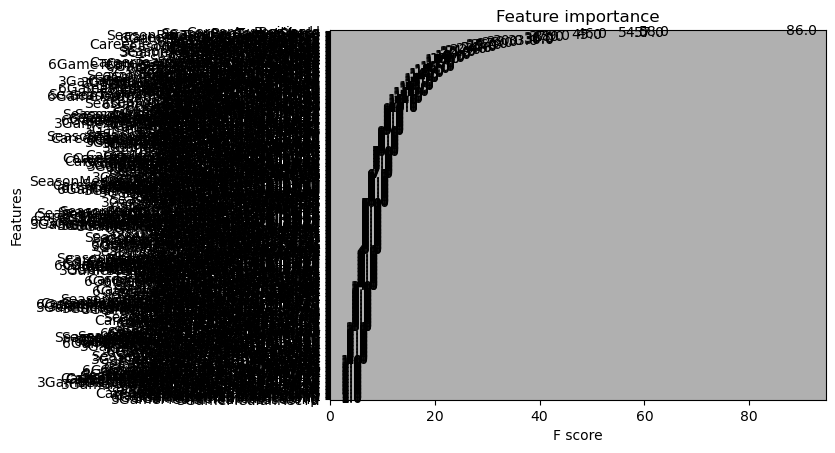

,TargetRecYards,pred_TargetRecYards,residuals
6983,28.0,20.334885,7.665115
1147,31.0,19.637486,11.362514
3682,39.0,19.684122,19.315878
15172,0.0,14.190286,-14.190286
16554,23.0,51.902534,-28.902534


In [9]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=300, 
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()


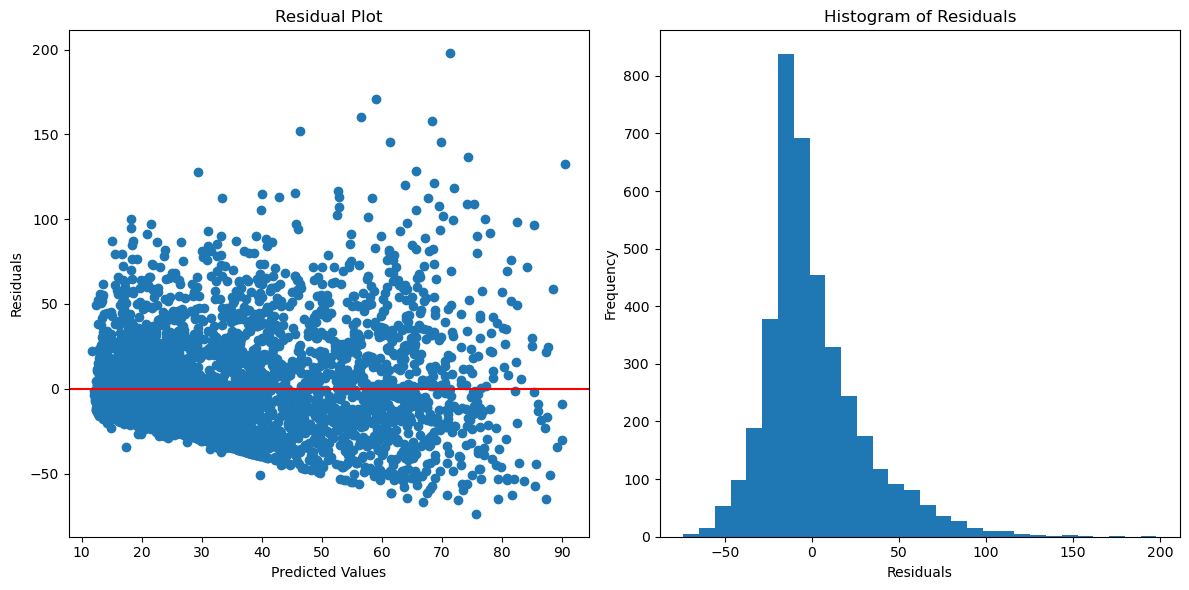

In [10]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

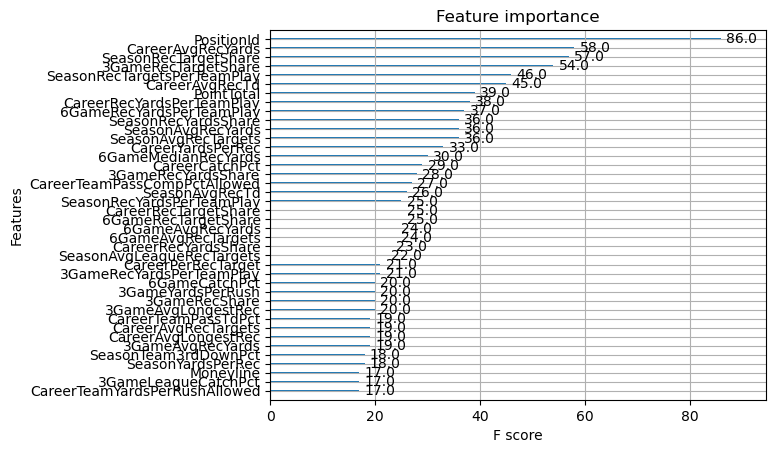

<Figure size 1800x1200 with 0 Axes>

In [11]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

In [12]:
train_test_data['x{}'.format(variable)] = best_xgb.predict(train_test_data[features])
train_test_data['Residual'] = train_test_data[target_variable] - train_test_data['x{}'.format(variable)]
train_test_data['AbsResidual'] = [np.abs(i) for i in train_test_data['Residual']]

train_test_data.sort_values('AbsResidual', ascending=False)[['GameDate','Player',target_variable,'x{}'.format(variable),'AbsResidual']].head(20)

,GameDate,Player,TargetRecYards,xRecYards,AbsResidual
18980,2020-11-29,Tyreek Hill,269.0,71.233849,197.766151
1102,2023-12-24,Amari Cooper,265.0,81.013206,183.986794
8450,2022-01-02,Ja'Marr Chase,266.0,83.426781,182.573219
4580,2023-10-05,DJ Moore,230.0,59.051807,170.948193
19278,2019-10-06,Will Fuller,217.0,56.488323,160.511677
1027,2019-10-06,Amari Cooper,226.0,68.348724,157.651276
11298,2021-10-10,Kadarius Toney,189.0,35.769775,153.230225
16745,2019-09-08,Sammy Watkins,198.0,46.316296,151.683704
1017,2018-12-09,Amari Cooper,217.0,67.405037,149.594963
16034,2020-11-05,Richie James,184.0,34.563023,149.436977


### Persist the best model in the models dir

In [13]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_prod.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_prod.pkl']

In [14]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_prod.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")